In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Renault.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Clio,Seri_Fluence,Seri_Grand Scenic,...,Model_TS,Model_TSW,Model_TX,Model_Toros,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,245000,2005,65,1461,557840,3.0,0.0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,499000,2016,90,1461,130000,NaN,NaN,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,235000,2004,80,1461,245000,6.0,1.0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,345000,2009,100,1461,154000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,817500,2021,115,1461,79530,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_7256\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,48550.938378,1.718183e+09,41450.976985,30156.482202


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:22:41,099] A new study created in memory with name: no-name-51bac525-d27a-4e1b-bd13-6650e432b9f6
[I 2023-10-08 14:22:41,427] Trial 2 finished with value: 392570.88889103197 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.013404061237553257, 'max_depth': 6, 'min_child_weight': 264}. Best is trial 2 with value: 392570.88889103197.
[I 2023-10-08 14:22:41,460] Trial 5 finished with value: 319935.7002349615 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.034563694328784055, 'max_depth': 15, 'min_child_weight': 292}. Best is trial 5 with value: 319935.7002349615.
[I 2023-10-08 14:22:41,490] Trial 0 finished with value: 60232.614246745856 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.24718393809463585, 'max_depth': 9, 'min_child_weight': 190}. Best is trial 0 with value: 60232.614246745856.
[I 2023-10-08 14:22:41,495] Trial 1 finished with value: 425376.32714528416 and parameters: {

[I 2023-10-08 14:22:42,980] Trial 28 finished with value: 218347.77409283415 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.07336913265356347, 'max_depth': 8, 'min_child_weight': 224}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:42,996] Trial 30 finished with value: 221432.14153062346 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.0718456918963596, 'max_depth': 8, 'min_child_weight': 231}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:43,291] Trial 32 finished with value: 199297.50597299007 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.08066883231997052, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:43,368] Trial 34 finished with value: 234995.4134778373 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.06419442265798037, 'max_depth': 5, 'min_child_weight'

[I 2023-10-08 14:22:45,216] Trial 60 finished with value: 112097.064632644 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.13893777953658115, 'max_depth': 13, 'min_child_weight': 23}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:45,380] Trial 61 finished with value: 116195.59868761177 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.13492291898105394, 'max_depth': 14, 'min_child_weight': 24}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:45,436] Trial 66 finished with value: 281536.837968652 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.0481523939880855, 'max_depth': 14, 'min_child_weight': 35}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:45,455] Trial 62 finished with value: 45369.9940645364 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3406928196518624, 'max_depth': 14, 'min_child_weight': 2

[I 2023-10-08 14:22:47,590] Trial 88 finished with value: 47448.50896371422 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.39098653945795836, 'max_depth': 14, 'min_child_weight': 29}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:47,595] Trial 89 finished with value: 49002.82235219649 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.35730816910351615, 'max_depth': 14, 'min_child_weight': 30}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:47,595] Trial 91 finished with value: 55304.59071848388 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.2425862488628648, 'max_depth': 14, 'min_child_weight': 6}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:47,602] Trial 93 finished with value: 47333.08928994305 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.3754719103787908, 'max_depth': 14, 'min_child_weight': 

[I 2023-10-08 14:22:49,819] Trial 120 finished with value: 45385.85479224573 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.3211894922310893, 'max_depth': 7, 'min_child_weight': 9}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:49,831] Trial 121 finished with value: 48807.794970992654 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.3221075529089256, 'max_depth': 7, 'min_child_weight': 75}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:49,929] Trial 122 finished with value: 62174.69059051428 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.20894075697604972, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 26 with value: 43793.07906491136.
[I 2023-10-08 14:22:49,966] Trial 123 finished with value: 88576.0414541352 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.16310792829010015, 'max_depth': 8, 'min_child_weight': 

[I 2023-10-08 14:22:52,313] Trial 149 finished with value: 43941.53713986273 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.45389675874611785, 'max_depth': 6, 'min_child_weight': 13}. Best is trial 140 with value: 42829.17265823661.
[I 2023-10-08 14:22:52,472] Trial 151 finished with value: 50674.49735884055 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.4954026555217327, 'max_depth': 6, 'min_child_weight': 3}. Best is trial 140 with value: 42829.17265823661.
[I 2023-10-08 14:22:52,570] Trial 152 finished with value: 47120.30801679027 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.49318227973911694, 'max_depth': 5, 'min_child_weight': 3}. Best is trial 140 with value: 42829.17265823661.
[I 2023-10-08 14:22:52,660] Trial 153 finished with value: 46598.09586164538 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4290634393024256, 'max_depth': 4, 'min_child_weight'

[I 2023-10-08 14:22:55,507] Trial 183 finished with value: 47932.145938191774 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2691379013695268, 'max_depth': 5, 'min_child_weight': 25}. Best is trial 140 with value: 42829.17265823661.
[I 2023-10-08 14:22:55,528] Trial 180 finished with value: 392301.6921717965 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.012393665834330877, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 140 with value: 42829.17265823661.
[I 2023-10-08 14:22:55,542] Trial 182 finished with value: 253868.22961611062 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.055733872405918275, 'max_depth': 5, 'min_child_weight': 24}. Best is trial 140 with value: 42829.17265823661.
[I 2023-10-08 14:22:55,625] Trial 181 finished with value: 49398.96396464708 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.26444563166487284, 'max_depth': 5, 'min_child_

[I 2023-10-08 14:22:58,001] Trial 210 finished with value: 43697.739173101356 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4318351813182248, 'max_depth': 6, 'min_child_weight': 29}. Best is trial 199 with value: 42789.886788772026.
[I 2023-10-08 14:22:58,074] Trial 211 finished with value: 42991.967720507884 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4313284429651713, 'max_depth': 6, 'min_child_weight': 11}. Best is trial 199 with value: 42789.886788772026.
[I 2023-10-08 14:22:58,152] Trial 214 finished with value: 314748.1063015133 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.034808947595749644, 'max_depth': 6, 'min_child_weight': 173}. Best is trial 199 with value: 42789.886788772026.
[I 2023-10-08 14:22:58,188] Trial 212 finished with value: 44478.10827372 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.495157053865302, 'max_depth': 6, 'min_child_wei

[I 2023-10-08 14:23:00,941] Trial 240 finished with value: 43036.61876013806 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.41935241728142436, 'max_depth': 7, 'min_child_weight': 35}. Best is trial 233 with value: 42593.25577320479.
[I 2023-10-08 14:23:01,475] Trial 244 finished with value: 187620.41753080263 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.085498685441618, 'max_depth': 7, 'min_child_weight': 35}. Best is trial 233 with value: 42593.25577320479.
[I 2023-10-08 14:23:01,545] Trial 242 finished with value: 50934.75223073176 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2512980069697469, 'max_depth': 7, 'min_child_weight': 35}. Best is trial 233 with value: 42593.25577320479.
[I 2023-10-08 14:23:01,550] Trial 243 finished with value: 53925.96711482651 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2347937527497827, 'max_depth': 7, 'min_child_weight

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 42593.2558
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.3542047063446282
	max_depth: 7
	min_child_weight: 22


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 52792.49230098558, 'MSE': 2005406014.8549776, 'RMSE': 44781.75984544352, 'MAE': 32288.91573503521}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.948706308404889

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.941605735394822

In [16]:
marka_model = joblib.dump(final_model, "Renault.pkl")

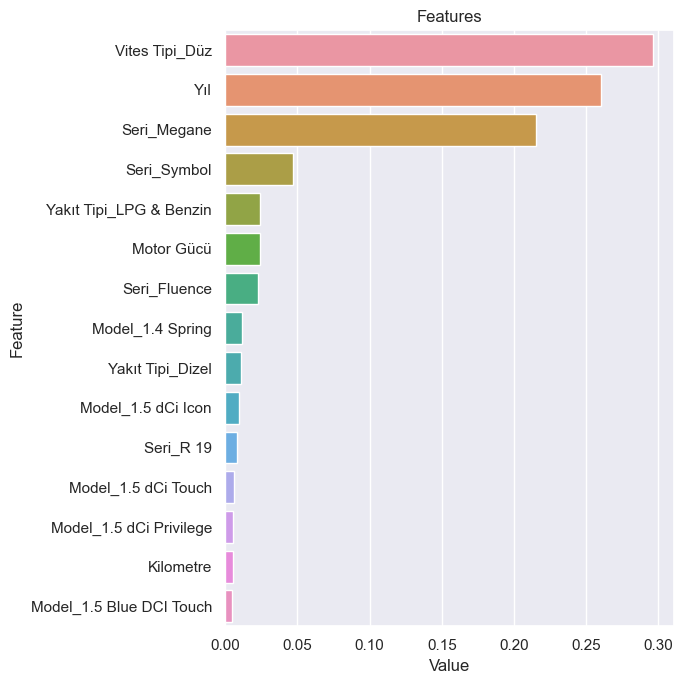

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)